In [1]:
import imageio.v3 as imageio
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

Loading the class and meta information and setting the training / validation split

In [2]:
classes=pd.read_csv('class_dict.csv') 
meta=pd.read_csv('metadata.csv')
train_meta_df = meta[meta['split'] == 'train']
meta_shuffled = train_meta_df.sample(frac=1).reset_index(drop=True)

# Splitting into training and test sets
train_size = int(0.85 * len(meta_shuffled))
training_meta = meta_shuffled[:train_size]
training_meta.reset_index(drop=True, inplace=True)
validation_meta = meta_shuffled[train_size:]
validation_meta.reset_index(drop=True, inplace=True)

Data generator class for terrain fraction detection model

In [3]:
class FractionDataset(tf.keras.utils.Sequence):

    def __init__(self, meta, batch_size, classes):
        self.meta = meta
        self.batch_size = batch_size
        self.classes = classes
    
    def __len__(self):
        return math.ceil(len(self.meta) / self.batch_size)

    def __getitem__(self, idx):
        start_idx = idx * self.batch_size
        end_idx = min((idx + 1) * self.batch_size, len(self.meta))
        
        batch_x = []
        batch_y = []
        
        for i in range(start_idx, end_idx):
            sat_image = imageio.imread(self.meta["sat_image_path"][i])
            mask_image = imageio.imread(self.meta["mask_path"][i])
            
            # Initialising empty arrays to hold class fractions
            class_fractions = np.zeros(len(self.classes))
            
            # Calculating total number of pixels
            total_pixels = np.prod(mask_image.shape[:2])
            
            for idx, class_info in self.classes.iterrows():
                target_rgb = class_info[['r', 'g', 'b']].values
                target_mask = np.all(mask_image == target_rgb, axis=-1).astype(np.uint8)
                
                # Calculating the number of pixels for this class
                class_pixels = np.sum(target_mask)
                
                # Calculating fraction of pixels for this class
                class_fraction = class_pixels / total_pixels
                
                class_fractions[idx] = class_fraction
            
            batch_x.append(sat_image / 255.0)
            batch_y.append(class_fractions)
        
        return np.array(batch_x), np.array(batch_y)


Convolutional Neural Network

In [4]:
model = models.Sequential([
    layers.Conv2D(32, (9, 9), padding='same', input_shape=(2448, 2448, 3)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),
    layers.GlobalAveragePooling2D(),
    layers.Dense(7, activation='softmax')
])

model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
model.summary()




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 2448, 2448, 32)    7808      
                                                                 
 batch_normalization (Batch  (None, 2448, 2448, 32)    128       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 2448, 2448, 32)    0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 1224, 1224, 32)    0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 1224, 1224, 32)    9248      
                                                                 
 batch_normalization_1 (Bat  (None, 1224, 1224, 32)  

Custom logging callback saving the validation and training loss / accuracy

In [5]:
class CustomLoggingCallback(tf.keras.callbacks.Callback):
    def __init__(self, log_every=8, val_log=60, val_dataset=None):
        self.log_every = log_every
        self.val_log = val_log
        self.batch_losses = []
        self.batch_accuracies = []
        self.batch_val_loss = []
        self.batch_val_accuracy = []
        self.batches = []
        self.validation_dataset = val_dataset

    def on_batch_end(self, batch, logs=None):
        if batch>0 and batch % self.log_every == 0:
            logs = logs or {}
            loss = logs.get('loss')
            accuracy = logs.get('accuracy')
            self.batch_losses.append(loss)
            self.batch_accuracies.append(accuracy)
            self.batches.append(batch)
            print(f'Batch {batch}: Loss: {loss}, Accuracy: {accuracy}')

        if batch > 0 and batch % self.val_log == 0:
            if self.validation_dataset is not None:
                val_loss, val_accuracy = self.model.evaluate(self.validation_dataset)
                self.batch_val_loss.append(val_loss)
                self.batch_val_accuracy.append(val_accuracy)
                print(f'Validation at batch {batch}: Loss: {val_loss}, Accuracy: {val_accuracy}')


Training code where satellite images are called through the dataset generator

In [6]:
batch_size = 4 

training_dataset = FractionDataset(training_meta, batch_size, classes)
validation_dataset = FractionDataset(validation_meta, batch_size, classes)

custom_logging_callback = CustomLoggingCallback(log_every=40, val_log= 40, val_dataset = validation_dataset)

model.fit(training_dataset, validation_data=validation_dataset, epochs = 3, steps_per_epoch= len(training_dataset), callbacks= custom_logging_callback)

Epoch 1/3


31/31 [==============================] - 446s 14s/step - loss: 0.0792 - accuracy: 0.1488
Validation at batch 40: Loss: 0.07915337383747101, Accuracy: 0.1487603336572647
31/31 [==============================] - 395s 12s/step - loss: 0.0841 - accuracy: 0.0413
Validation at batch 80: Loss: 0.08405356854200363, Accuracy: 0.041322313249111176
31/31 [==============================] - 415s 13s/step - loss: 0.0630 - accuracy: 0.6116
Validation at batch 120: Loss: 0.06304857134819031, Accuracy: 0.6115702390670776
31/31 [==============================] - 412s 13s/step - loss: 0.0569 - accuracy: 0.6612
Validation at batch 160: Loss: 0.05694408714771271, Accuracy: 0.6611570119857788
171/171 [==============================] - 5740s 34s/step - loss: 0.0517 - accuracy: 0.6646 - val_loss: 0.0433 - val_accuracy: 0.6612
Epoch 2/3
31/31 [==============================] - 357s 11s/step - loss: 0.0477 - accuracy: 0.6612
Validation at batch 40: Loss: 0.047667473554611206, Accuracy: 0.66115701198

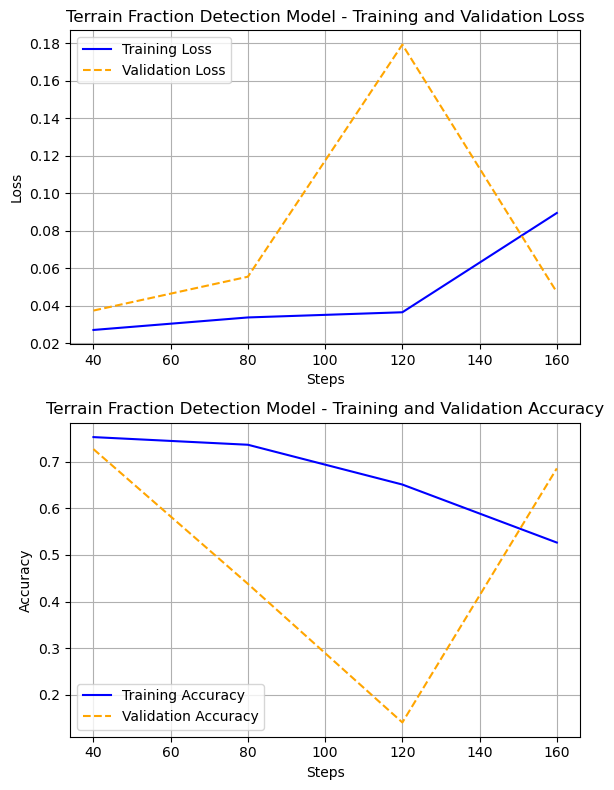

In [7]:
# Retrieving logged data
steps = custom_logging_callback.batches
batch_losses = custom_logging_callback.batch_losses
batch_accuracies = custom_logging_callback.batch_accuracies
batch_val_loss = custom_logging_callback.batch_val_loss
batch_val_accuracy = custom_logging_callback.batch_val_accuracy

# Determining the total number of batches in each epoch
batches_per_epoch = len(steps) // 3  

# Determining the starting index of the last epoch
start_index_last_epoch = batches_per_epoch * 2

# Retrieving the relevant logged data for the last epoch
last_epoch_steps = steps[start_index_last_epoch:]
last_epoch_batch_losses = batch_losses[start_index_last_epoch:]
last_epoch_batch_val_loss = batch_val_loss[start_index_last_epoch:]
last_epoch_batch_accuracies = batch_accuracies[start_index_last_epoch:]
last_epoch_batch_val_accuracy = batch_val_accuracy[start_index_last_epoch:]

# Creating lists to hold all data points
combined_steps = []
combined_losses = []
combined_val_losses = []
combined_accuracies = []
combined_val_accuracies = []

# Iterating over the steps, losses, and accuracies
for step, loss, accuracy in zip(last_epoch_steps, last_epoch_batch_losses, last_epoch_batch_accuracies):
    combined_steps.append(step)
    combined_losses.append(loss)
    combined_accuracies.append(accuracy)

# Iterating over the validation steps, losses, and accuracies
val_step_index = 0
for step, val_loss, val_accuracy in zip(last_epoch_steps, last_epoch_batch_val_loss, last_epoch_batch_val_accuracy):
    # Only including validation metrics at specified intervals
    if step % custom_logging_callback.val_log == 0:
        combined_val_losses.append(val_loss)
        combined_val_accuracies.append(val_accuracy)
    else:
        # Fill with None for steps where validation metrics are not logged
        combined_val_losses.append(None)
        combined_val_accuracies.append(None)


plt.figure(figsize=(6, 8))

# Plotting training and validation loss
plt.subplot(2, 1, 1)
plt.plot(combined_steps, combined_losses, label='Training Loss', color='blue')
plt.plot(combined_steps, combined_val_losses, label='Validation Loss', color='orange', linestyle='--')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Terrain Fraction Detection Model - Training and Validation Loss')
plt.legend()
plt.grid(True)

# Plotting training and validation accuracy
plt.subplot(2, 1, 2)
plt.plot(combined_steps, combined_accuracies, label='Training Accuracy', color='blue')
plt.plot(combined_steps, combined_val_accuracies, label='Validation Accuracy', color='orange', linestyle='--')
plt.xlabel('Steps')
plt.ylabel('Accuracy')
plt.title('Terrain Fraction Detection Model - Training and Validation Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [8]:
model.save("FRACTION_MODEL_FINAL.keras")